In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import random
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error


c:\Users\Bluewind\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def define_files():
    files = {
        "air_pollution_death": "data/air_pollution_death.csv",
        "transportation": 'data/road-transportation_country_emissions.csv',
        "coal": 'data/coal-mining_country_emissions.csv',
        "cropland": 'data/cropland-fires_country_emissions.csv',
        "residential_commercial": 'data/residential-and-commercial-onsite-fuel-usage_country_emissions.csv',
        "forest_clearing": 'data/forest-land-clearing_country_emissions.csv',
        "petrochemicals": 'data/petrochemicals_country_emissions.csv',
        "electricity_generation": 'data/electricity-generation_country_emissions.csv',
        "incineration_open_burning": 'data/incineration-and-open-burning-of-waste_country_emissions.csv',
        "health_expenditure": 'data/health-expenditure.csv',
        "urban_population": 'data/urban-population.csv'
    }
    return files

files = define_files()
files


{'air_pollution_death': 'data/air_pollution_death.csv',
 'transportation': 'data/road-transportation_country_emissions.csv',
 'coal': 'data/coal-mining_country_emissions.csv',
 'cropland': 'data/cropland-fires_country_emissions.csv',
 'residential_commercial': 'data/residential-and-commercial-onsite-fuel-usage_country_emissions.csv',
 'forest_clearing': 'data/forest-land-clearing_country_emissions.csv',
 'petrochemicals': 'data/petrochemicals_country_emissions.csv',
 'electricity_generation': 'data/electricity-generation_country_emissions.csv',
 'incineration_open_burning': 'data/incineration-and-open-burning-of-waste_country_emissions.csv',
 'health_expenditure': 'data/health-expenditure.csv',
 'urban_population': 'data/urban-population.csv'}

In [3]:
def find_common_country_codes(env_list, socio_list, files):
    env_codes = []
    for key in env_list:
        df = pd.read_csv(files[key])
        codes = set(df['iso3_country'].unique())
        env_codes.append(codes)
    common_env_codes = set.intersection(*env_codes) if env_codes else set()

    # Process socioeconomic files
    socio_codes = []
    for key in socio_list:
        df = pd.read_csv(files[key], skiprows=4)
        country_col = None
        for col in df.columns:
            if col.strip().replace(" ", "").lower() == "countrycode":
                country_col = col
                break
        if country_col is None:
            raise ValueError(f"Expected country code column not found in {files[key]}")
        codes = set(df[country_col].unique())
        socio_codes.append(codes)
    common_socio_codes = set.intersection(*socio_codes) if socio_codes else set()

    return sorted(list(common_env_codes.intersection(common_socio_codes)))

# Define environment and socio-economic factors
environment_factor_files_list = [
    'transportation', 'coal', 'cropland',
    'residential_commercial', 'forest_clearing',
    'petrochemicals', 'electricity_generation',
    'incineration_open_burning'
]
socioeconomic_files_list = ['health_expenditure', 'urban_population']

common_country_codes = find_common_country_codes(environment_factor_files_list, socioeconomic_files_list, files)
common_country_codes[:10]  # Display first 10 common country codes


['AFG', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATG', 'AUS', 'AUT']

In [4]:
air_pollution_df = pd.read_csv(files["air_pollution_death"])
filtered_air_pollution_df = air_pollution_df[
    (air_pollution_df['SpatialDimValueCode'].isin(common_country_codes)) &
    (air_pollution_df['Period'] == 2018) &
    (air_pollution_df['Dim1'] == 'Both sexes')
]

filtered_air_pollution_df.to_csv('filtered_air_deaths.csv', index=False)
filtered_air_pollution_df.head()


IndicatorCode                                  Indicator ValueType  \
3294        AIR_41  Ambient air pollution attributable deaths   numeric   
3298        AIR_41  Ambient air pollution attributable deaths   numeric   
3309        AIR_41  Ambient air pollution attributable deaths   numeric   
3318        AIR_41  Ambient air pollution attributable deaths   numeric   
3323        AIR_41  Ambient air pollution attributable deaths   numeric   

     ParentLocationCode   ParentLocation Location type SpatialDimValueCode  \
3294                AMR         Americas       Country                 ATG   
3298                AFR           Africa       Country                 COM   
3309                AMR         Americas       Country                 BHS   
3318                WPR  Western Pacific       Country                 KIR   
3323                AMR         Americas       Country                 VCT   

                              Location Period type  Period  ...  FactValueUoM  \
3294               Antigua and Barbuda        Year    2018  ...           NaN   
3298                           Comoros        Year    2018  ...           NaN   
3309                           Bahamas        Year    2018  ...           NaN   
3318                          Kiribati        Year    2018  ...           NaN   
3323  Saint Vincent and the Grenadines        Year    2018  ...           NaN   

     FactValueNumericLowPrefix FactValueNumericLow FactValueNumericHighPrefix  \
3294                       NaN               0.071                        NaN   
3298                       NaN               0.019                        NaN   
3309                       NaN               0.022                        NaN   
3318                       NaN               0.000                        NaN   
3323                       NaN               0.120                        NaN   

     FactValueNumericHigh    Value FactValueTranslationID  FactComments  \
3294                 0.49  0 [0-0]                    NaN           NaN   
3298                 0.13  0 [0-0]                    NaN           NaN   
3309                 1.14  0 [0-1]                    NaN           NaN   
3318                 1.23  0 [0-1]                    NaN           NaN   
3323                 0.68  0 [0-1]                    NaN           NaN   

      Language              DateModified  
3294        EN  2024-10-02T16:00:00.000Z  
3298        EN  2024-10-02T16:00:00.000Z  
3309        EN  2024-10-02T16:00:00.000Z  
3318        EN  2024-10-02T16:00:00.000Z  
3323        EN  2024-10-02T16:00:00.000Z  

[5 rows x 34 columns]

In [5]:
environment_data = []
socioeconomic_data = []

for key in environment_factor_files_list:
    df = pd.read_csv(files[key])
    df_filtered = df[
        (df['iso3_country'].isin(common_country_codes)) &
        (df['start_time'] >= '2018-01-01 00:00:00')
    ]
    df_grouped = df_filtered.groupby('iso3_country', as_index=False)['emissions_quantity'].sum()
    df_grouped.rename(columns={'iso3_country': 'Country Code', 'emissions_quantity': key}, inplace=True)
    environment_data.append(df_grouped)

for key in socioeconomic_files_list:
    df = pd.read_csv(files[key], skiprows=4)
    df_filtered = df[df['Country Code'].isin(common_country_codes)]
    df_filtered = df_filtered[['Country Code', '2018']].rename(columns={'2018': key})
    socioeconomic_data.append(df_filtered)


In [6]:
deaths_by_country = filtered_air_pollution_df.groupby(['SpatialDimValueCode'])['FactValueNumeric'].sum().reset_index()
deaths_by_country.rename(columns={'SpatialDimValueCode': 'Country Code', 'FactValueNumeric': 'deaths'}, inplace=True)

environment_merged = environment_data[0]
for df in environment_data[1:]:
    environment_merged = pd.merge(environment_merged, df, on="Country Code", how="outer")

final_merged = environment_merged
for df in socioeconomic_data:
    final_merged = pd.merge(final_merged, df, on="Country Code", how="outer")

final_merged = pd.merge(final_merged, deaths_by_country, on="Country Code", how="outer")
final_merged_cleaned = final_merged.dropna()
final_merged_cleaned = final_merged_cleaned[final_merged_cleaned['Country Code'] != 'CHN']
final_merged_cleaned = final_merged_cleaned[final_merged_cleaned['Country Code'] != 'IND']
final_merged_cleaned.to_csv('real_merged_data3.csv', index=False)

final_merged_cleaned.head()


Country Code  transportation          coal      cropland  \
0          AFG    5.728724e+07  1.237991e+07  3.047164e+07   
1          AGO    1.657005e+08  0.000000e+00  7.027087e+07   
2          ALB    2.535625e+07  3.709218e+05  1.866232e+06   
4          ARE    5.190228e+08  0.000000e+00  1.601377e+05   
5          ARG    6.409067e+08  1.997271e+05  7.706948e+08   

   residential_commercial  forest_clearing  petrochemicals  \
0            8.294334e+06     8.632059e+04    0.000000e+00   
1            4.872556e+07     1.024659e+09    0.000000e+00   
2            1.147137e+07     4.995076e+06    0.000000e+00   
4            9.554346e+06     0.000000e+00    7.280612e+07   
5            5.821784e+08     4.487951e+08    1.150682e+07   

   electricity_generation  incineration_open_burning  health_expenditure  \
0            1.929000e+06               6.095110e+05          299.787491   
1            3.753900e+07               5.018776e+05          182.326689   
2            0.000000e+00               2.078827e+05          896.791354   
4            1.217688e+09               1.615316e+06         3002.587776   
5            7.590450e+08               2.238038e+06         2401.319013   

   urban_population    deaths  
0         9353296.0  44151.00  
1        20488542.0  16997.28  
2         1728969.0   6088.43  
4         7908257.0   3599.55  
5        40877099.0  34992.30

In [52]:
X = final_merged_cleaned.drop(columns=['Country Code',  'deaths'])
y = final_merged_cleaned['deaths']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

xgb_model = xgb.XGBRegressor(
    tree_method='hist',
    n_estimators=200, #600
    learning_rate=0.065, #0.065
    max_depth=3, #1
    gamma=0, #1
    
    subsample=0.3, #0.042
    colsample_bytree=0.7, #1
    reg_alpha=10, #80000
    reg_lambda=10, #60
    random_state=random_seed
)

evalset = [(X_train_scaled, y_train), (X_test_scaled,y_test)]
xgb_model.fit(X_train_scaled, y_train, eval_set=evalset)
y_train_pred = xgb_model.predict(X_train_scaled)
y_test_pred = xgb_model.predict(X_test_scaled)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
result = xgb_model.evals_result()

final_train_r2 = train_r2
final_test_r2 = test_r2
print(xgb_model.score(X_test_scaled, y_test))
print(f"Train R² Score: {train_r2:.4f}")
print(f"Test R² Score: {test_r2:.4f}")


[0]	validation_0-rmse:48523.49604	validation_1-rmse:27370.18834
[1]	validation_0-rmse:47983.89626	validation_1-rmse:26691.61926
[2]	validation_0-rmse:47626.88276	validation_1-rmse:26226.61281
[3]	validation_0-rmse:46891.12082	validation_1-rmse:25517.12447
[4]	validation_0-rmse:46390.41574	validation_1-rmse:24858.65736


[5]	validation_0-rmse:45607.31157	validation_1-rmse:24157.79300
[6]	validation_0-rmse:45225.09538	validation_1-rmse:23549.91868
[7]	validation_0-rmse:44906.49814	validation_1-rmse:23167.13107
[8]	validation_0-rmse:44515.66025	validation_1-rmse:22828.34174
[9]	validation_0-rmse:43777.61753	validation_1-rmse:22345.61140
[10]	validation_0-rmse:43251.40356	validation_1-rmse:21610.86791
[11]	validation_0-rmse:42679.40080	validation_1-rmse:20974.00067
[12]	validation_0-rmse:41940.10566	validation_1-rmse:20277.48427
[13]	validation_0-rmse:41662.69978	validation_1-rmse:20065.88206
[14]	validation_0-rmse:41396.63692	validation_1-rmse:19807.64208
[15]	validation_0-rmse:40972.01428	validation_1-rmse:19378.64056
[16]	validation_0-rmse:40658.52249	validation_1-rmse:19034.66185
[17]	validation_0-rmse:40221.37551	validation_1-rmse:18744.37932
[18]	validation_0-rmse:40064.03569	validation_1-rmse:18642.63889
[19]	validation_0-rmse:39654.42018	validation_1-rmse:18264.59863
[20]	validation_0-rmse:39592.4

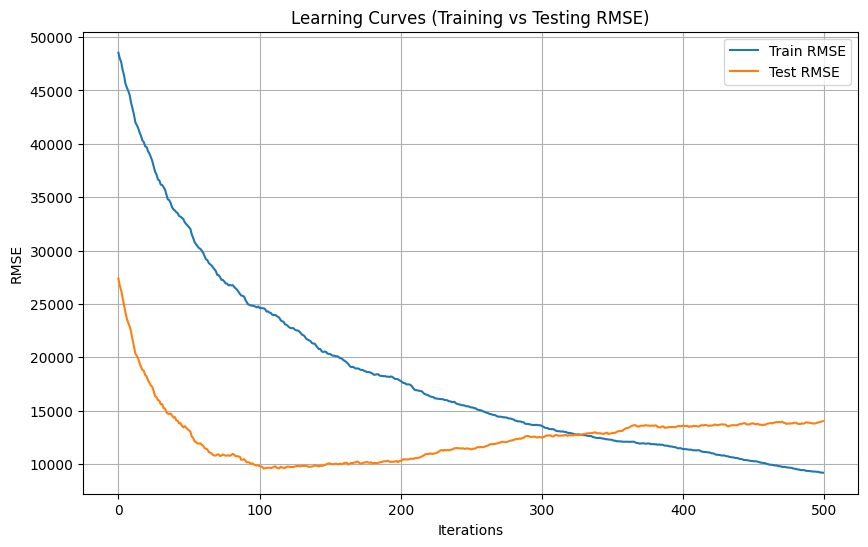

In [28]:
iterations = len(result['validation_0']['rmse'])
x_axis = range(0, iterations)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, result['validation_0']['rmse'], label='Train RMSE')  # Train error (RMSE)
plt.plot(x_axis, result['validation_1']['rmse'], label='Test RMSE')  # Test error (RMSE)
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Learning Curves (Training vs Testing RMSE)')
plt.legend()
plt.grid(True)
plt.show()

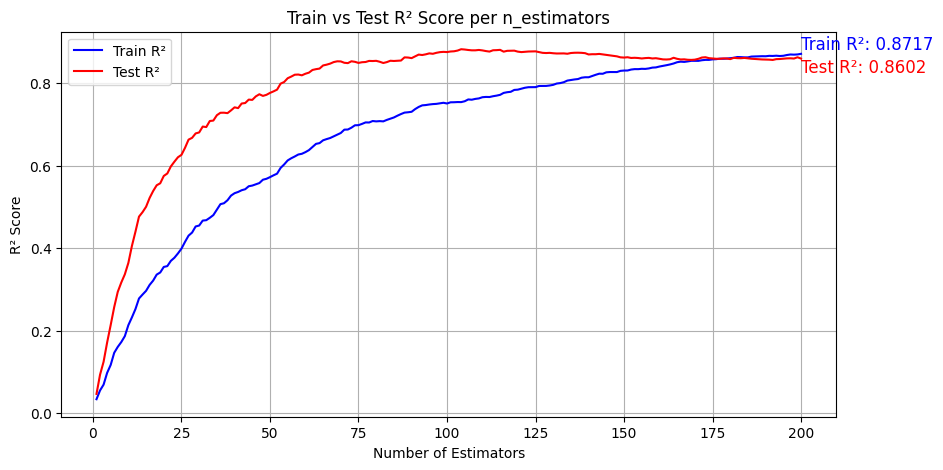

In [ ]:
train_r2_scores = [
    r2_score(y_train, xgb_model.predict(X_train_scaled, iteration_range=(0, i))) for i in range(1, xgb_model.n_estimators + 1)
]
test_r2_scores = [
    r2_score(y_test, xgb_model.predict(X_test_scaled, iteration_range=(0, i))) for i in range(1, xgb_model.n_estimators + 1)
]

# Plot the train vs. test R² scores
plt.figure(figsize=(10, 5))
plt.plot(range(1, xgb_model.n_estimators+1), train_r2_scores, label="Train R²", color='blue')
plt.plot(range(1, xgb_model.n_estimators+1), test_r2_scores, label="Test R²", color='red')
plt.xlabel("Number of Estimators")
plt.ylabel("R² Score")
plt.title("Train vs Test R² Score per n_estimators")
plt.text(xgb_model.n_estimators, final_train_r2, f'  Final Train R²: {final_train_r2:.4f}', 
         fontsize=12, color='blue', verticalalignment='bottom')

plt.text(xgb_model.n_estimators, final_test_r2, f'   Final Test R²: {final_test_r2:.4f}', 
         fontsize=12, color='red', verticalalignment='top')
plt.legend()
plt.grid()
plt.show()

In [16]:
param_grid = {
    'n_estimators': [200, 300, 400, 600, 800],
    'learning_rate': [0.01, 0.05, 0.065, 0.1], 
    'max_depth': [1, 2, 3, 4, 5] ,
    'gamma': [0, 1, 2],
    
    'subsample': [0.3, 0.4, 0.42, 0.48, 0.5],
    'colsample_bytree': [0.7, 0.8, 0.9, 1],
    'reg_alpha': [1000, 5000, 10000, 80000],
    'reg_lambda': [10, 50, 100] 
}

# Prepare data
X = final_merged_cleaned.drop(columns=['Country Code', 'deaths'])
y = final_merged_cleaned['deaths']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

# Initialize results container
results = []
best = []
count = 1

try:
# Perform manual grid search
    for n_estimators in param_grid['n_estimators']:
        for learning_rate in param_grid['learning_rate']:
            for max_depth in param_grid['max_depth']:
                for subsample in param_grid['subsample']:
                    for colsample_bytree in param_grid['colsample_bytree']:
                        for gamma in param_grid['gamma']:
                            for reg_alpha in param_grid['reg_alpha']:
                                for reg_lambda in param_grid['reg_lambda']:
                                    # Define and train model
                                    xgb_model = xgb.XGBRegressor(
                                        tree_method='hist',
                                        n_estimators=n_estimators,
                                        learning_rate=learning_rate, 
                                        max_depth=max_depth, 
                                        gamma=gamma,
                                        subsample=subsample, 
                                        colsample_bytree=colsample_bytree, 
                                        reg_alpha=reg_alpha, 
                                        reg_lambda=reg_lambda,
                                        random_state=random_seed
                                    )
                                    
                                    xgb_model.fit(X_train_scaled, y_train)
                                    
                                    # Make predictions
                                    y_train_pred = xgb_model.predict(X_train_scaled)
                                    y_test_pred = xgb_model.predict(X_test_scaled)

                                    # Calculate R² score for both train and test sets
                                    train_r2 = r2_score(y_train, y_train_pred)
                                    test_r2 = r2_score(y_test, y_test_pred)
                                    
                                    print("Iteration " + str(count) + "  Test R2 Score: " + str(test_r2))
                                    count += 1
                                    # Store the results
                                    if test_r2 < train_r2 and test_r2 > 0.80:
                                        results.append({
                                            'n_estimators': n_estimators,
                                            'learning_rate': learning_rate,
                                            'max_depth': max_depth,
                                            'subsample': subsample,
                                            'gamma': gamma,
                                            'reg_alpha': reg_alpha,
                                            'reg_lambda': reg_lambda,
                                            'train_r2': train_r2,
                                            'test_r2': test_r2
                                        })

except KeyboardInterrupt:
    ##best_params = max(results, key=lambda x: x['test_r2'])
    print(f'Program terminated at Iteration: {count}')
    print(results)
    #print(f'Best Hyperparameters: {best_params}')
    #print(f"Best Test R² Score: {best_params['test_r2']:.4f}")

# Find the best set of hyperparameters based on the test R² score
# best_params = max(results, key=lambda x: x['test_r2'])

# # Print the best hyperparameters and the corresponding R² scores
# print(f"Best Hyperparameters: {best_params}")
# print(f"Best Test R² Score: {best_params['test_r2']:.4f}")

Iteration 1  Test R2 Score: 0.6943456615826359
Iteration 2  Test R2 Score: 0.43099644829343986
Iteration 3  Test R2 Score: 0.2938012013206054
Iteration 4  Test R2 Score: 0.6933794843622519
Iteration 5  Test R2 Score: 0.42951952104757873
Iteration 6  Test R2 Score: 0.29195661576106446
Iteration 7  Test R2 Score: 0.6917736986520855
Iteration 8  Test R2 Score: 0.42643234958091814
Iteration 9  Test R2 Score: 0.28960134623227063
Iteration 10  Test R2 Score: 0.6430850182946437
Iteration 11  Test R2 Score: 0.3835164942792829
Iteration 12  Test R2 Score: 0.25631928896585154
Iteration 13  Test R2 Score: 0.6943456615826359
Iteration 14  Test R2 Score: 0.43099644829343986
Iteration 15  Test R2 Score: 0.2938012013206054
Iteration 16  Test R2 Score: 0.6933794843622519
Iteration 17  Test R2 Score: 0.42951952104757873
Iteration 18  Test R2 Score: 0.29195661576106446
Iteration 19  Test R2 Score: 0.6917736986520855
Iteration 20  Test R2 Score: 0.42643234958091814
Iteration 21  Test R2 Score: 0.28960134

In [18]:
print(results)
best_params = max(results, key=lambda x: x['test_r2'])
print(f'Best Hyperparameters: {best_params}')
print(f"Best Test R² Score: {best_params['test_r2']:.4f}")

[{'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 1, 'subsample': 0.4, 'gamma': 0, 'reg_alpha': 5000, 'reg_lambda': 10, 'train_r2': 0.8071509739663763, 'test_r2': 0.8054444620131639}, {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 1, 'subsample': 0.4, 'gamma': 0, 'reg_alpha': 10000, 'reg_lambda': 10, 'train_r2': 0.8053662130794891, 'test_r2': 0.8040746254898454}, {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 1, 'subsample': 0.4, 'gamma': 1, 'reg_alpha': 5000, 'reg_lambda': 10, 'train_r2': 0.8071509739663763, 'test_r2': 0.8054444620131639}, {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 1, 'subsample': 0.4, 'gamma': 1, 'reg_alpha': 10000, 'reg_lambda': 10, 'train_r2': 0.8053662130794891, 'test_r2': 0.8040746254898454}, {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 1, 'subsample': 0.4, 'gamma': 2, 'reg_alpha': 5000, 'reg_lambda': 10, 'train_r2': 0.8071509739663763, 'test_r2': 0.8054444620131639}, {'n_estimators': 200, 'learning_rate'

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 600, 800],
    'learning_rate': [0.01, 0.05, 0.065, 0.1], 
    'max_depth': [1, 2, 3, 4, 5] ,
    'gamma': [0, 1, 2],
    
    'subsample': [0.3, 0.4, 0.42, 0.48, 0.5],
    'colsample_bytree': [0.7, 0.8, 0.9, 1],
    'reg_alpha': [1000, 5000, 10000, 80000],
    'reg_lambda': [10, 50, 100]
}

# Prepare data
X = final_merged_cleaned.drop(columns=['Country Code', 'deaths'])
y = final_merged_cleaned['deaths']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

# Initialize results container
results = []
best = []
count = 1
# Perform manual grid search
for n_estimators in param_grid['n_estimators']:
    for learning_rate in param_grid['learning_rate']:
        for max_depth in param_grid['max_depth']:
            for subsample in param_grid['subsample']:
                for colsample_bytree in param_grid['colsample_bytree']:
                    for gamma in param_grid['gamma']:
                        for reg_alpha in param_grid['reg_alpha']:
                            for reg_lambda in param_grid['reg_lambda']:
                                # Define and train model
                                xgb_model = xgb.XGBRegressor(
                                    tree_method='hist',
                                    n_estimators=n_estimators,
                                    learning_rate=learning_rate, 
                                    max_depth=max_depth, 
                                    gamma=gamma,
                                    subsample=subsample, 
                                    colsample_bytree=colsample_bytree, 
                                    reg_alpha=reg_alpha, 
                                    reg_lambda=reg_lambda,
                                    random_state=random_seed
                                )
                                
                                xgb_model.fit(X_train_scaled, y_train)
                                
                                # Make predictions
                                y_train_pred = xgb_model.predict(X_train_scaled)
                                y_test_pred = xgb_model.predict(X_test_scaled)

                                # Calculate R² score for both train and test sets
                                train_r2 = r2_score(y_train, y_train_pred)
                                test_r2 = r2_score(y_test, y_test_pred)
                                
                                print("Iteration " + str(count) + "  Test R2 Score: " + str(test_r2))
                                count += 1
                                # Store the results
                                if test_r2 > train_r2 and test_r2 > 87:
                                    results.append({
                                        'n_estimators': n_estimators,
                                        'learning_rate': learning_rate,
                                        'max_depth': max_depth,
                                        'subsample': subsample,
                                        'gamma': gamma,
                                        'reg_alpha': reg_alpha,
                                        'reg_lambda': reg_lambda,
                                        'train_r2': train_r2,
                                        'test_r2': test_r2
                                    })

                                

# Find the best set of hyperparameters based on the test R² score
best_params = max(results, key=lambda x: x['test_r2'])

# Print the best hyperparameters and the corresponding R² scores
print(f"Best Hyperparameters: {best_params}")
print(f"Best Test R² Score: {best_params['test_r2']:.4f}")

Iteration 1  Test R2 Score: 0.48636163089211015
Iteration 2  Test R2 Score: 0.2528757027017364
Iteration 3  Test R2 Score: 0.15836323861453305
Iteration 4  Test R2 Score: 0.48350687512235
Iteration 5  Test R2 Score: 0.25123645813326845
Iteration 6  Test R2 Score: 0.15716957895091466
Iteration 7  Test R2 Score: 0.483343182469018
Iteration 8  Test R2 Score: 0.24907119577393466
Iteration 9  Test R2 Score: 0.15567528812910014
Iteration 10  Test R2 Score: 0.43178121676194237
Iteration 11  Test R2 Score: 0.2198122284778704
Iteration 12  Test R2 Score: 0.13485610479266563
Iteration 13  Test R2 Score: 0.48636163089211015
Iteration 14  Test R2 Score: 0.2528757027017364
Iteration 15  Test R2 Score: 0.15836323861453305
Iteration 16  Test R2 Score: 0.48350687512235
Iteration 17  Test R2 Score: 0.25123645813326845
Iteration 18  Test R2 Score: 0.15716957895091466
Iteration 19  Test R2 Score: 0.483343182469018
Iteration 20  Test R2 Score: 0.24907119577393466
Iteration 21  Test R2 Score: 0.15567528812

KeyboardInterrupt: 

In [260]:
best_params = max(results, key=lambda x: x['test_r2'])

# Print the best hyperparameters and the corresponding R² scores
print(f"Best Hyperparameters: {best_params}")
print(f"Best Test R² Score: {best_params['test_r2']:.4f}")

Best Hyperparameters: {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.3, 'gamma': 1, 'reg_alpha': 1000, 'reg_lambda': 100, 'train_r2': 0.7189667667377965, 'test_r2': 0.9062603747138765}
Best Test R² Score: 0.9063


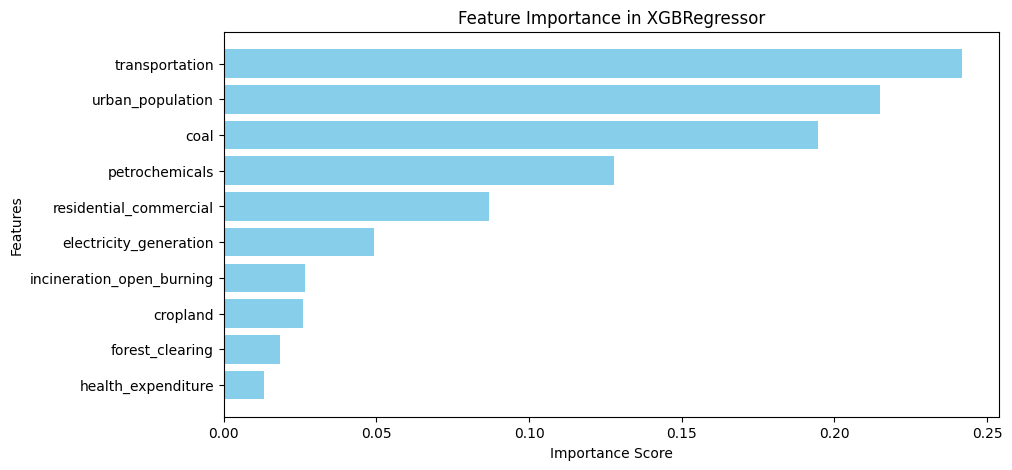

In [213]:
feature_importance = xgb_model.feature_importances_

# Get feature names from DataFrame
feature_names = X_train.columns  

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance in XGBRegressor')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

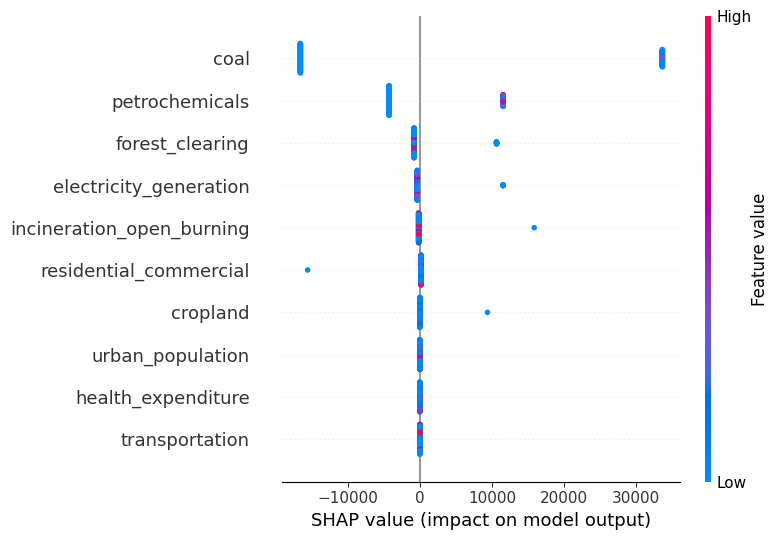

In [214]:
def generate_beeswarm_plot(X_train, model):
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_train)
    shap.summary_plot(shap_values, X_train, plot_type="dot")

generate_beeswarm_plot(X_train, xgb_model)


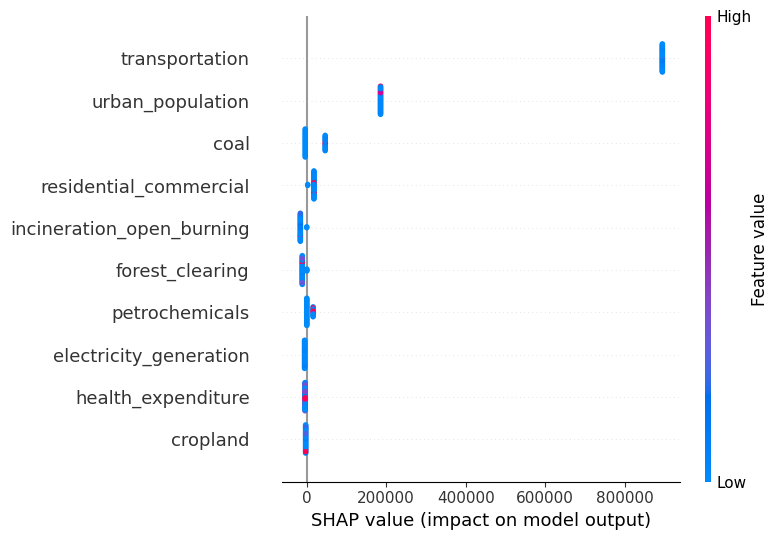

In [ ]:
explainer = shap.Explainer(xgb_model)  # For tree-based models like XGBoost

# Calculate SHAP values
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)
explainer = shap.TreeExplainer(xgb_model)

# Get SHAP values for the test set (X_test)
shap_values = explainer.shap_values(X_test)

# Now use shap.force_plot:
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])


Number of data points for China: 1
Number of data points for Other Countries: 175


IndexError: positional indexers are out-of-bounds

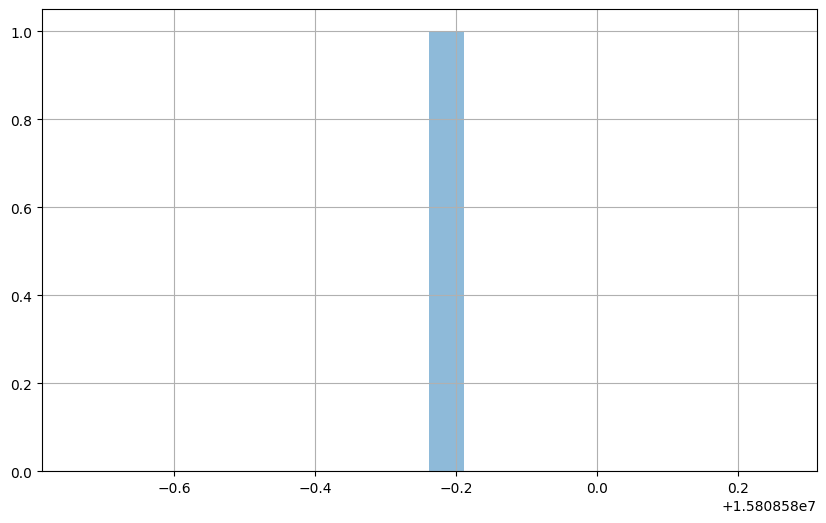

In [ ]:
# Get indices for China and other countries correctly
china_index = final_merged_cleaned[final_merged_cleaned['Country Code'] == 'CHN'].index
other_index = final_merged_cleaned[final_merged_cleaned['Country Code'] != 'CHN'].index

# Check the number of data points for both groups
print(f"Number of data points for China: {len(china_index)}")
print(f"Number of data points for Other Countries: {len(other_index)}")

# Ensure that the feature is numeric
numeric_features = X_test.select_dtypes(include=['number']).columns

# Plot for numeric features only
for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    
    # Plot for China
    X_test.iloc[china_index, X_test.columns.get_loc(feature)].hist(alpha=0.5, label="China", bins=20)
    
    # Plot for Other Countries
    X_test.iloc[other_index, X_test.columns.get_loc(feature)].hist(alpha=0.5, label="Other Countries", bins=20)
    
    plt.legend()
    plt.title(f"Distribution of {feature} for China and Others")
    plt.show()


In [39]:
# Calculate correlation
correlation = final_merged_cleaned[['health_expenditure', 'deaths']].corr().iloc[0, 1]

# Create scatter plot
fig = px.scatter(final_merged_cleaned, x='health_expenditure', y='deaths', hover_data=['Country Code'])

# Annotate correlation on the plot
fig.add_annotation(
    x=max(final_merged_cleaned['health_expenditure']),
    y=max(final_merged_cleaned['deaths']),
    text=f"Correlation: {correlation:.4f}",
    showarrow=False,
    font=dict(size=14, color="red")
)

fig.show()


In [14]:
with open("coding_test_output.html", "w", encoding="utf-8") as f:
    f.write("""
    <html>
        <head><title>Air Pollution and Emissions Analysis</title></head>
        <body><h1>Air Pollution Deaths by Country</h1></body>
    </html>
    """)
